In [2]:
import os
import random
import numpy as np
import cv2
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Picking a Random Folder

In [32]:
# create a list of availble folders in the data
# and pick a random folder
folder = random.choice([name for name in os.listdir('Data_MIT/')])
# folder = '00358'


## Reading the JSON Files

In [33]:
# name and path of the data folder on my system
path = 'Data_MIT/' + folder

# Face Crop
with open(path + '/appleFace.json', 'r') as file:
    face = json.load(file)
    
# Left Eye
with open(path + '/appleLeftEye.json', 'r') as file:
    eye_l = json.load(file)

# Right Eye
with open(path + '/appleRightEye.json', 'r') as file:
    eye_r = json.load(file)

# Face Grid
with open(path + '/faceGrid.json', 'r') as file:
    grid = json.load(file)
    
# Info
with open(path + '/info.json', 'r') as file:
    info = json.load(file)

# dot
with open(path + '/dotInfo.json', 'r') as file:
    dot = json.load(file)


## Picking a Random File

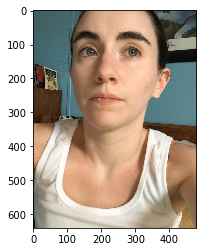

In [34]:
# make a list of indices of the invalid Frames in the Folder
# a frame could be invalid because of the face not being in the frame
# (not detected) or because of the left eye not being in the frame,
# or the right eye
# if all of these three values are valid, the frame's grid is valid
indices = [i for i, x in enumerate(face['IsValid']) if x == 0]
indices += [i for i, x in enumerate(eye_l['IsValid']) if x == 0]
indices += [i for i, x in enumerate(eye_r['IsValid']) if x == 0]
indices += [i for i, x in enumerate(grid['IsValid']) if x == 0]

# make a list out of all invalid indices
indices = list(set(indices))

# read and make list of all files in the folder
path = 'Data_MIT/' + folder + '/frames/'
files = [name for name in os.listdir(path)]

# keep picking a random file as long as its index in the
# invalid indices list
idx = indices[0]
while idx in indices:
    file = random.choice(files)
    idx = files.index(file)

# idx = 2331    

# plot the frame    
img = cv2.cvtColor(cv2.imread(path + files[idx]), cv2.COLOR_BGR2RGB)
# plt.axis('off')
plt.imshow(img);

## Plots

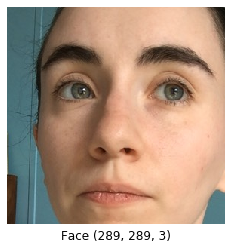

In [36]:
# first we have to check to make sure the stupid face bounding box
# didn't fall out of the frame
# X,Y is the coordinate of the top-left corner of the bounding box,
# so four offisde cases are possible:

# 1. X is negative
if round(face['X'][idx]) < 0:
    # so we fill the shortage by replicating the edge 
    img = cv2.copyMakeBorder(img, 0, 0, np.abs(round(face['X'][idx])), 0, cv2.BORDER_REPLICATE)
    # and reset the X value regarding the new frame
    face['X'][idx] = 0
    print('Negative X\n')

# 2. Y is negative
if round(face['Y'][idx]) < 0:
    # so we fill the shortage by replicating the edge 
    img = cv2.copyMakeBorder(img, np.abs(round(face['Y'][idx])), 0, 0, 0, cv2.BORDER_REPLICATE)
    # and reset the Y value regarding the new frame
    face['Y'][idx] = 0
    print('Negative Y\n')

# 3. X+W is larger than the frame width
if round(face['X'][idx])+round(face['W'][idx]) > img.shape[1]:
    # so we fill the shortage (diff) by replicating the edge
    diff = np.abs(img.shape[1]-(round(face['X'][idx])+round(face['W'][idx])))
    img = cv2.copyMakeBorder(img, 0, 0, 0, diff, cv2.BORDER_REPLICATE)
    print('Face box out of the right border\n')

# 4. Y+H is larger than the frame height
if round(face['Y'][idx])+round(face['H'][idx]) > img.shape[0]:
    # so we fill the shortage (diff) by replicating the edge
    diff = np.abs(img.shape[0]-(round(face['Y'][idx])+round(face['H'][idx])))
    img = cv2.copyMakeBorder(img, 0, diff, 0, 0, 0, cv2.BORDER_REPLICATE)
    print('Face box out of the lower border\n')


# read the position of the top-left corner of the bounding box of the face (X,Y)
# and the its height (H) and width (W), and get the face patch
crop = img[round(face['Y'][idx]):round(face['Y'][idx])+round(face['H'][idx]),
           round(face['X'][idx]):round(face['X'][idx])+round(face['W'][idx])]


# plot, resize, and save the face patch
# turn off the axes
plt.axis('off')
# add the title, and
plt.title('Face ' + str(crop.shape), y=-.1)
# plot it
plt.imshow(crop)

# set the path to save the images in the test folder
# being named: folder_file_f.png (f stands for face patch)
path_test = 'Data_test/' + str(folder) + '_' + str(idx) + '_f.png'
# resize the image
crop_res = cv2.resize(crop, (224, 224))
# and save the face path
cv2.imwrite(path_test, cv2.cvtColor(crop_res, cv2.COLOR_BGR2RGB));



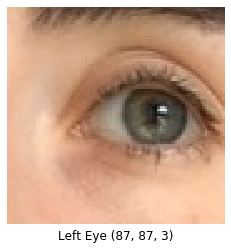

In [37]:
# read the position of the top-left corner of the bounding box of the left eye (X,Y)
# and the its height (H) and width (W), and recalculate the coordinate respecting the
# original frame (because some frames have negative coordinates for eye patches, too.)
eyel_x = round(eye_l['X'][idx]) + round(face['X'][idx])
eyel_y = round(eye_l['Y'][idx]) + round(face['Y'][idx])

# and get the left eye patch
eyel = img[eyel_y:eyel_y+round(eye_l['H'][idx]),
           eyel_x:eyel_x+round(eye_l['W'][idx])]

# plot, resize, and save the face patch
# turn off the axes
plt.axis('off')
# add the title, and
plt.title('Left Eye ' + str(eyel.shape), y=-.1)
# plot it
plt.imshow(eyel)

# set the path to save the images in the test folder
# being named: folder_file_l.png (l stands for left eye patch)
path_test = 'Data_test/' + str(folder) + '_' + str(idx) + '_l.png'
# resize the image
eyel_res = cv2.resize(eyel, (224, 224))
# and save the face path
cv2.imwrite(path_test, cv2.cvtColor(eyel_res, cv2.COLOR_BGR2RGB));


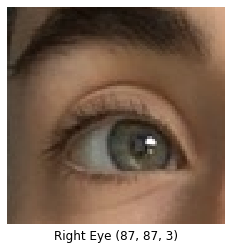

In [38]:
# read the position of the top-left corner of the bounding box of the right eye (X,Y)
# and the its height (H) and width (W), and recalculate the coordinate respecting the
# original frame (because some frames have negative coordinates for eye patches, too.)
eyer_x = round(eye_r['X'][idx]) + round(face['X'][idx])
eyer_y = round(eye_r['Y'][idx]) + round(face['Y'][idx])

# and get the right eye patch
eyer = img[eyer_y:eyer_y+round(eye_r['H'][idx]),
           eyer_x:eyer_x+round(eye_r['W'][idx])]


# plot, resize, and save the face patch
# turn off the axes
plt.axis('off')
# add the title, and
plt.title('Right Eye ' + str(eyer.shape), y=-.1)
# plot it
plt.imshow(eyer)

# set the path to save the images in the test folder
# being named: folder_file_r.png (r stands for right eye patch)
path_test = 'Data_test/' + str(folder) + '_' + str(idx) + '_r.png'
# resize the image
eyer_res = cv2.resize(eyer, (224, 224))
# and save the face path
cv2.imwrite(path_test, cv2.cvtColor(eyer_res, cv2.COLOR_BGR2RGB));


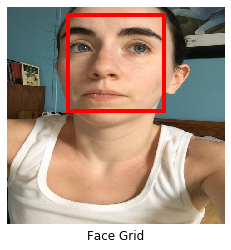

In [41]:
fig, ax = plt.subplots()

# read the position of the top-left corner of the bounding box of the face grid (X,Y)
# and the its height (H) and width (W), and plot it with a red rectabgle patch
# within a 25X25-resized version of the frame
grid_patch = patches.Rectangle((round(grid['X'][idx]),25-round(grid['Y'][idx])-round(grid['H'][idx])),
                               round(grid['W'][idx]),round(grid['H'][idx]),
                               linewidth=1,edgecolor='r',facecolor='none')

# add the patch to the resized frame canvas
ax.add_patch(grid_patch)
# turn the axes off
ax.axis('off')
# add the title, and
plt.title('Face Grid', y=-.1)
# plot
ax.imshow(img, extent=[0,25,0,25]);

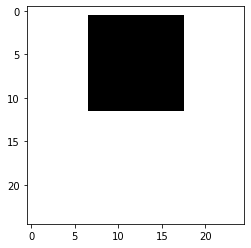

In [40]:
# now save the face gird as a black rectangle on a white 25X25 canvas
# set the path to save the images in the test folder
# being named: folder_file_g.png (g stands for face grid patch)
path_test = 'test/' + str(folder) + '_' + str(idx) + '_g.png'


# set the canvas
canvas = np.ones((25,25))*255

# grid coordinates
y = round(grid['Y'][idx])
x = round(grid['X'][idx])
h = round(grid['H'][idx])
w = round(grid['W'][idx])
# mask the face location
canvas[y:y+h, x:x+w] = 0

# plot, and
plt.imshow(canvas, cmap='gray')

# set the path to save the images in the test folder
# being named: folder_file_g.png (g stands for face grid)
path_test = 'Data_test/' + str(folder) + '_' + str(idx) + '_g.jpg'
# save the face grid
cv2.imwrite(path_test, canvas);

## The Frame

In [27]:
path[9:] + files[idx]

'00721/frames/01020.jpg'

## Info

In [28]:
# check the information about the subject/folder
info

{'TotalFrames': 1126,
 'NumFaceDetections': 1017,
 'NumEyeDetections': 779,
 'Dataset': 'test',
 'DeviceName': 'iPhone 5C'}

In [29]:
sum(grid['IsValid']), sum(face['IsValid']), sum(eye_l['IsValid']), sum(eye_r['IsValid'])

(1017, 1017, 779, 779)

## Label

In [42]:
# read the four positions in the dot info
label = np.array([dot['XPts'][idx], dot['YPts'][idx], dot['XCam'][idx], dot['YCam'][idx]])
label

array([164.68096614, 682.90293121,  -4.38902197,   7.50264704])

In [31]:
eye_l['X'][idx], eye_l['Y'][idx], eye_r['X'][idx], eye_r['Y'][idx]

(162.3664, 37.24002, 50.64639, 32.77124)